In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [2]:
cd data/

D:\Documents\Tugas\Anaconda\data_50u_35i\data


In [3]:
names = ['user_id', 'item_id', 'rating']
df = pd.read_csv('reviews_50u_35i_ready.csv', sep=',', names=names)
df.head()

,user_id,item_id,rating
0,1,7159,5
1,1,7164,3
2,1,7941,3
3,1,7948,5
4,1,7950,4


In [4]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
print str(n_users) + ' users'
print str(n_items) + ' items'
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

8625 users
25877 items
Sparsity: 0.41%


In [6]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                       size=10,replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    assert(np.all((train * test) == 0))
    return train, test

In [7]:
train, test = train_test_split(ratings)

In [7]:
from ExplicitMF import ExplicitMF

In [9]:
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse: 0.8752063629356145
Test mse: 0.8765809957140829
Iteration: 2
Train mse: 0.8603859773492043
Test mse: 0.8651531246043279
Iteration: 5
Train mse: 0.8267327763242515
Test mse: 0.8399145170534281
Iteration: 10
Train mse: 0.7907393105698765
Test mse: 0.8141897551754134
Iteration: 25
	current iteration: 10
Train mse: 0.7405283155053887
Test mse: 0.781876119619642
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.7116021654002166
Test mse: 0.7680537412135559
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.677868293292404
Test mse: 0.764666785923276
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.4848495133338102
Test mse: 0.7766119918890019


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, label='Test', linewidth=5)
    
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

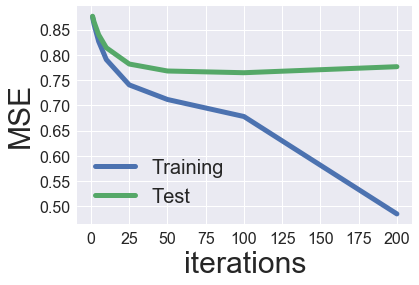

In [11]:
plot_learning_curve(iter_array, MF_SGD)

In [12]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for rate in learning_rates:
    print 'Rate: {}'.format(rate)
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:        
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print 'New optimal hyperparameters'
        print pd.Series(best_params)

Rate: 1e-05
New optimal hyperparameters
learning_rate                                                1e-05
model            <ExplicitMF.ExplicitMF instance at 0x000000000...
n_iter                                                         200
test_mse                                                  0.865158
train_mse                                                 0.860392
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                               0.0001
model            <ExplicitMF.ExplicitMF instance at 0x000000000...
n_iter                                                         200
test_mse                                                  0.788713
train_mse                                                 0.752006
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                                0.001
model            <ExplicitMF.ExplicitMF instance at 0x000000000...
n_iter                                         

In [13]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularizations: {}'.format(reg)
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                           user_fact_reg=reg, item_fact_reg=reg,\
                           user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test,\
                                        learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print 'New optimal hyperparameters'
            print pd.Series(best_params)

Factors: 5
Regularizations: 0.001
New optimal hyperparameters
model        <ExplicitMF.ExplicitMF instance at 0x000000000...
n_factors                                                    5
n_iter                                                      50
reg                                                      0.001
test_mse                                              0.775969
train_mse                                             0.699106
dtype: object
Regularizations: 0.01
New optimal hyperparameters
model        <ExplicitMF.ExplicitMF instance at 0x000000000...
n_factors                                                    5
n_iter                                                      50
reg                                                       0.01
test_mse                                              0.774411
train_mse                                             0.700211
dtype: object
Regularizations: 0.1
New optimal hyperparameters
model        <ExplicitMF.ExplicitMF instance at 0x00000

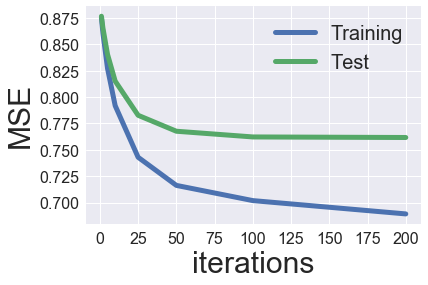

In [14]:
plot_learning_curve(iter_array, best_params['model'])

In [15]:
print 'Best regularization: {}'.format(best_params['reg'])
print 'Best latent factors: {}'.format(best_params['n_factors'])
print 'Best iterations: {}'.format(best_params['n_iter'])

Best regularization: 0.1
Best latent factors: 20
Best iterations: 200


In [10]:
iter_array = [200]
latent_factors = [20, 40, 80]
regularizations = [0.01, 0.1]
regularizations.sort()

cur_params = {}
cur_params['n_factors'] = latent_factors[0]
cur_params['reg'] = regularizations[0]
cur_params['n_iter'] = 0
cur_params['train_mse'] = np.inf
cur_params['test_mse'] = np.inf
cur_params['model'] = None

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularizations: {}'.format(reg)
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                           user_fact_reg=reg, item_fact_reg=reg,\
                           user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test,\
                                        learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        
        cur_params['n_factors'] = fact
        cur_params['reg'] = reg
        cur_params['n_iter'] = iter_array[min_idx]
        cur_params['train_mse'] = MF_SGD.train_mse[min_idx]
        cur_params['test_mse'] = MF_SGD.test_mse[min_idx]
        cur_params['model'] = MF_SGD
        print 'Current optimal hyperparameters'
        print pd.Series(cur_params)
            
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print 'New optimal hyperparameters'
            print pd.Series(best_params)

Factors: 20
Regularizations: 0.01


KeyboardInterrupt: 

In [8]:
best_sgd_model = ExplicitMF(ratings, n_factors=20, learning='sgd', \
                            item_fact_reg=0.1, user_fact_reg=0.1, \
                            user_bias_reg=0.1, item_bias_reg=0.1)
best_sgd_model.train(200, learning_rate=0.001)

In [102]:
from IPython.display import HTML

def display_top_k_books(similarity, idx_to_book, book_idx, k=10):
    book_indices = np.argsort(similarity[book_idx,:])[::-1]
    book_idx_list = ''
    k_ctr = 0
    # Start i at 1 to not grab the input book
    i = 0
    while k_ctr < 10:
        book = idx_to_book[book_indices[i]]
        if book != '':
            book_idx_list += "<h4>- %s<h4/>"\
                      % book
            k_ctr += 1
        i += 1
    display(HTML(book_idx_list))

def compare_recs(sgd_similarity,\
                 idx_to_book, book_idx, k=10):

    # Display SGD Recs
    display(HTML('<font size=5>'+'SGD Recs'+'</font>'))
    display_top_k_books(sgd_similarity,\
                          idx_to_book, book_idx)

In [104]:
def cosine_similarity(model):
    sim = model.item_vecs.dot(model.item_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

sgd_sim = cosine_similarity(best_sgd_model)

MemoryError: 

In [105]:
import io
# Load in book data
idx_to_book = {}

with io.open('reviews_50u_35i_info_items.csv', mode='r', encoding='utf-8-sig') as f:
    for line in f.readlines():
        info = line.split(',')        
        if len(info[1]) <= 10:
            for asin_char in xrange(len(info[1]), 11):
                info[1] = '0' + info[1]
        
        idx_to_book[int(info[0])-1] = info[0] + ' : ' + info[1]    

In [108]:
idx = 18808 
compare_recs(sgd_sim, idx_to_book, idx)